**Uncomment the cell below in google collab**
- delete # sign at the beginning

In [1]:
# !git clone https://github.com/recepgul82/music-digital-methods.git
# !pip install -r music-digital-methods/setup/requirements.txt

**The cell below is only for logistics. Just run it and disregard**

In [2]:
import sys
from pathlib import Path

def find_repo_root(marker_dir="course_code"):
    # Search upward from current working directory first
    p = Path.cwd().resolve()
    for _ in range(10):
        if (p / marker_dir).is_dir():
            return p
        if p == p.parent:
            break
        p = p.parent

    # If not found, search common top locations (e.g., Colab /content) without hardcoding repo name
    for base in [Path("/content"), Path.cwd().resolve()]:
        if base.exists():
            for candidate in base.rglob(marker_dir):
                if candidate.is_dir():
                    return candidate.parent

    raise RuntimeError(f"Could not locate repo root containing '{marker_dir}/'.")

REPO_ROOT = find_repo_root("course_code")
print("REPO_ROOT =", REPO_ROOT)

sys.path.insert(0, str(REPO_ROOT))



REPO_ROOT = /Users/recepgul/Desktop/ITU/Teaching/Doktora/LEE904E/music-digital-methods


# Case Study 1 — Retrieving and Analyzing Music Metadata via API

Goal:
1) Retrieve track metadata from the Kworb Listings
2) Perform simple descriptive statistics
3) Reflect on bias and representation
4) Get extra metadata information like genre and date using Deezer API


**Imports**
- Import the modules we will use in this task

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import List, Optional, Dict

pd.set_option('display.float_format', '{:.0f}'.format)

# 1) Retrieve track metadata from the Kworb Listings


### Helper Functions
- construct kworb spotify urls specific to countries
- fetch tables from the web using urls

In [4]:
def build_kworb_url(country_code: str) -> str:
    """
    Construct Kworb Spotify weekly totals URL for a given country code.
    
    Parameters
    ----------
    country_code : str
        ISO country code (e.g., 'us', 'tr')
        
    Returns
    -------
    str
        Full URL string
    """
    base_url = "https://kworb.net/spotify/country"
    return f"{base_url}/{country_code.lower()}_weekly_totals.html"


In [5]:
def fetch_weekly_table(country_code: str) -> pd.DataFrame:
    """
    Fetch weekly Spotify totals table for a country.
    
    Parameters
    ----------
    country_code : str
        
    Returns
    -------
    pd.DataFrame
    """
    url = build_kworb_url(country_code)
    tables = pd.read_html(url)
    
    if not tables:
        raise ValueError("No tables found on page.")
    
    return tables[0]


- Let us test if our functions correctly retrieved the tables

In [6]:
df_us_raw = fetch_weekly_table("us")
df_us_raw.head()

,Artist and Title,Wks,T10,Pk,(x?),PkStreams,Total
0,J. Cole - No Role Modelz,510,1,10,NaN,4946936,1248840407
1,Post Malone - Sunflower - Spider-Man: Into the...,315,45,1,(x6),14731867,1181577968
2,The Neighbourhood - Sweater Weather,365,6,8,NaN,5562447,1060912262
3,Juice WRLD - Lucid Dreams,262,26,1,(x1),13963947,928829032
4,"Tyler, The Creator - See You Again",241,9,5,NaN,7700794,882340160


### Some more Helper funcitons

Because the data we have some structural issues. We first need to handle them.
- clean column names and standardize them
- clean numeric columns
- split artist - title column into separate ones
- build dataset

In [7]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize column names.
    """
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df


In [8]:
def clean_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert numeric-like columns to integers.
    """
    df = df.copy()
    
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace(",", "", regex=False)
            if df[col].str.isnumeric().all():
                df[col] = pd.to_numeric(df[col])
                
    return df


In [9]:
def split_artist_title(df: pd.DataFrame, column_name: str = "artist_and_title") -> pd.DataFrame:
    """
    Split combined 'Artist - Title' column into separate columns.
    """
    df = df.copy()
    
    if column_name not in df.columns:
        raise ValueError(f"{column_name} not found in dataframe.")
    
    split_data = df[column_name].str.split(" - ", n=1, expand=True)
    
    df["artist"] = split_data[0]
    df["title"] = split_data[1]
    
    return df


In [10]:
def build_country_dataset(country_code: str) -> pd.DataFrame:
    """
    Full pipeline:
    - Fetch data
    - Clean column names
    - Clean numeric values
    - Split artist and title
    - Add country label
    """
    df = fetch_weekly_table(country_code)
    df = clean_column_names(df)
    df = clean_numeric_columns(df)
    df = split_artist_title(df, column_name="artist_and_title")
    
    df["country"] = country_code.lower()
    
    return df


- We now test how our functions will work

In [11]:
df_us = build_country_dataset("us")
df_tr = build_country_dataset("tr")
df_tr.head()


,artist_and_title,wks,t10,pk,(x?),pkstreams,total,artist,title,country
0,Madrigal - Seni Dert Etmeler,273,44,1,(x5),1754209,265865164,Madrigal,Seni Dert Etmeler,tr
1,Dolu Kadehi Ters Tut - Gitme,357,NaN,13,NaN,1241421,237643825,Dolu Kadehi Ters Tut,Gitme,tr
2,BLOK3 - SEVMEYİ DENEMEDİN,74,53,1,(x6),5282270,211046910,BLOK3,SEVMEYİ DENEMEDİN,tr
3,BLOK3 - aklına ben gelicem,125,14,1,(x3),5284158,204830744,BLOK3,aklına ben gelicem,tr
4,Mavi Gri - Altüst Olmuşum,228,NaN,11,NaN,1829099,204682602,Mavi Gri,Altüst Olmuşum,tr


In [12]:
df_us.head()

,artist_and_title,wks,t10,pk,(x?),pkstreams,total,artist,title,country
0,J. Cole - No Role Modelz,510,1,10,NaN,4946936,1248840407,J. Cole,No Role Modelz,us
1,Post Malone - Sunflower - Spider-Man: Into the...,315,45,1,(x6),14731867,1181577968,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,us
2,The Neighbourhood - Sweater Weather,365,6,8,NaN,5562447,1060912262,The Neighbourhood,Sweater Weather,us
3,Juice WRLD - Lucid Dreams,262,26,1,(x1),13963947,928829032,Juice WRLD,Lucid Dreams,us
4,"Tyler, The Creator - See You Again",241,9,5,NaN,7700794,882340160,"Tyler, The Creator",See You Again,us


## 📊 Understanding Kworb “Weekly Totals” Columns

The following columns appear in Kworb Spotify Weekly Totals listings:

### Column Descriptions

- **Artist and Title**  
  The combined artist name and track title as displayed on Kworb.

- **Wks**  
  Number of weeks the track has appeared on the chart.

- **T10**  
  Number of weeks the track has spent inside the Top 10 positions.

- **Pk**  
  Peak chart position achieved (1 = highest rank).

- **(x?)**  
  When shown in parentheses next to `Pk`, indicates separate runs at that peak position (e.g., `2(x1)` may indicate one distinct run at position 2).

- **PkStreams**  
  Number of streams during the week when the track reached its peak position.

- **Total**  
  Total cumulative streams across all weeks included in the dataset.

---

### Example Interpretation

A row like:Wks = 12, T10 = 6, Pk = 3, PkStreams = 1,234,567, Total = 12,345,678, 

Means:

- The track appeared on the chart for 12 weeks.
- It spent 6 of those weeks in the Top 10.
- Its highest position was #3.
- It received 1,234,567 streams during its peak week.
- Across all chart weeks, it accumulated 12,345,678 total streams.




# 2) Perform simple descriptive statistics

In [13]:
df_tr.describe()

,wks,t10,pk,pkstreams,total
count,6068,759,6068,6068,6068
mean,20,8,84,585885,8639853
std,32,8,63,944848,20927430
min,1,1,1,1005,1005
25%,2,2,27,71574,250060
50%,7,6,74,294672,1090942
75%,25,12,134,689481,5883706
max,479,68,270,16161219,265865164


In [14]:
df_us.describe()

,wks,t10,pk,pkstreams,total
count,9486,1163,9486,9486,9486
mean,13,6,81,3700548,34376662
std,26,7,62,3567477,81419230
min,1,1,1,67174,67174
25%,1,1,25,1725047,2227215
50%,3,2,67,2601028,6531284
75%,13,8,129,4413335,26241096
max,510,45,278,49012720,1248840407


# 3) Visualize Data

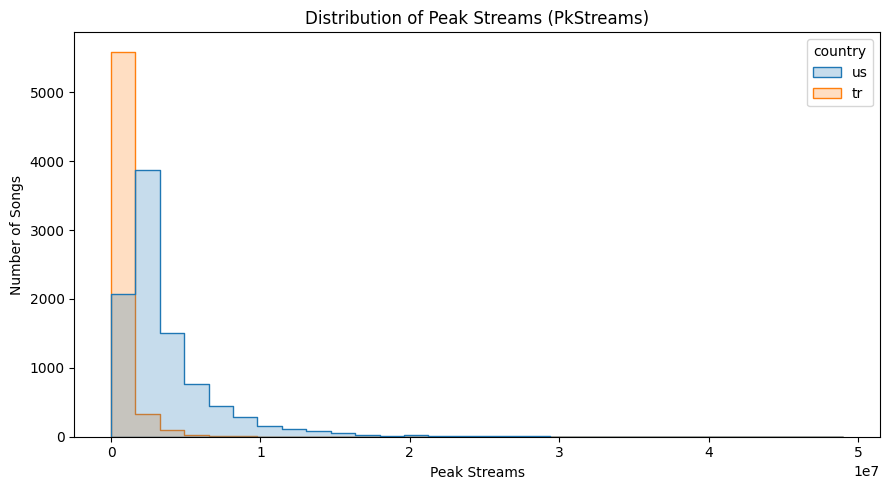

In [15]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt

df_combined = pd.concat([df_us, df_tr], ignore_index=True)

plt.figure(figsize=(9, 5))

sns.histplot(
    data=df_combined[df_combined["country"].isin(["us", "tr"])],
    x="pkstreams",
    hue="country",
    bins=30,
    stat="count",
    element="step",
    common_norm=False
)

plt.title("Distribution of Peak Streams (PkStreams)")
plt.xlabel("Peak Streams")
plt.ylabel("Number of Songs")

plt.tight_layout()
plt.show()





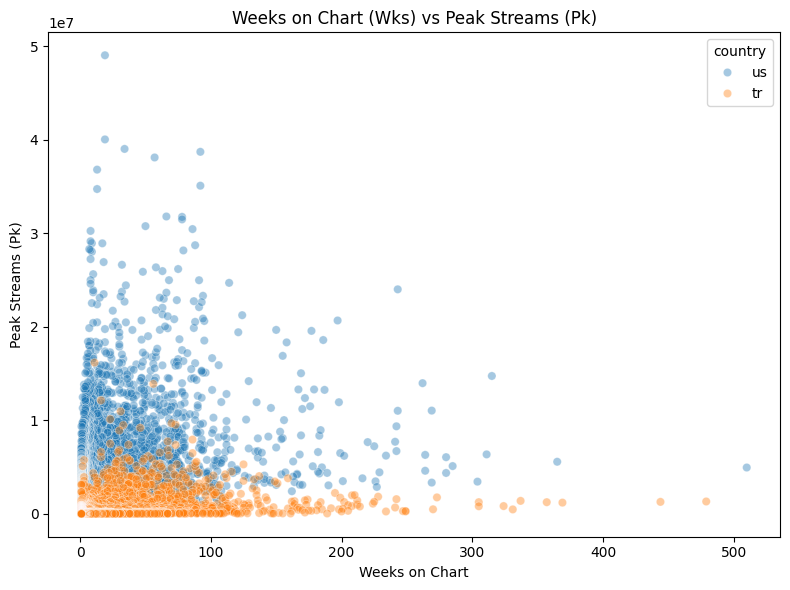

In [16]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_combined[df_combined["country"].isin(["us", "tr"])],
    x="wks",
    y="pkstreams",
    hue="country",
    alpha=0.4
)

plt.title("Weeks on Chart (Wks) vs Peak Streams (Pk)")
plt.xlabel("Weeks on Chart")
plt.ylabel("Peak Streams (Pk)")

plt.tight_layout()
plt.show()


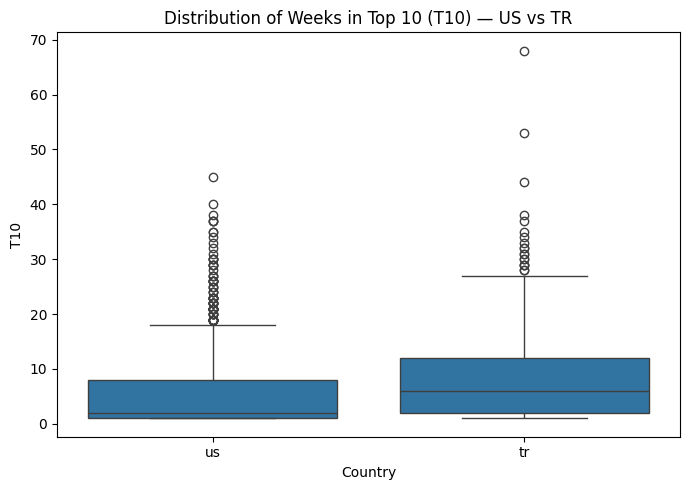

In [17]:
plt.figure(figsize=(7, 5))

sns.boxplot(
    data=df_combined[df_combined["country"].isin(["us", "tr"])],
    x="country",
    y="t10"
)

plt.title("Distribution of Weeks in Top 10 (T10) — US vs TR")
plt.xlabel("Country")
plt.ylabel("T10")

plt.tight_layout()
plt.show()


# 4) Get extra metadata information like genre and date using Deezer API

In [18]:
def get_deezer_metadata(artist: str, title: str, include_genres: bool = True) -> Dict | None:
    """
    Query Deezer API for track info: release_date and genres.
    Returns a dict with these fields or None if not found.
    """
    base_url = "https://api.deezer.com"
    
    # Build search query (use double quotes for accurate matching) 
    query = f"artist:\"{artist}\" track:\"{title}\""
    search_url = f"{base_url}/search/track?q={query}"
    
    res = requests.get(search_url)
    if res.status_code != 200:
        return None
    
    results = res.json().get("data", [])
    if not results:
        return None
    
    # Pick first result
    track_info = results[0]
    track_id = track_info.get("id")
    
    # Get album details via returned track
    album_info = track_info.get("album", {})
    album_id = album_info.get("id")
    if not album_id:
        return None
    
    album_url = f"{base_url}/album/{album_id}"
    res_album = requests.get(album_url)
    if res_album.status_code != 200:
        return None
    
    album_data = res_album.json()
    
    return {
        "track_id": track_id,
        "release_date": album_data.get("release_date"),
        "genres": [g.get("name") for g in album_data.get("genres", {}).get("data", [])] 
                  if include_genres else []
    }

**Test if the function is working**

In [19]:
info = get_deezer_metadata("Adele", "Hello")
print(info)

{'track_id': 138545995, 'release_date': '2015-11-20', 'genres': ['Pop']}


- We sample first 100 tracks from each country as retrieving track info via individual requests is slow in an API

In [20]:
df_sampled = pd.concat([df_us.head(100), df_tr.head(100)], ignore_index=True) # Only sample the first 100 tracks for speed

In [21]:
from tqdm import tqdm

# --- Enrichment cell ---
success_count = 0
failure_count = 0

# Prepare new columns
df_sampled["deezer_track_id"] = None
df_sampled["deezer_release_date"] = None
df_sampled["deezer_genres"] = None

# Loop through dataset rows
for idx, row in tqdm(df_sampled.iterrows(), total=df_sampled.shape[0]):
    artist = row["artist"]
    title = row["title"]
    
    metadata = get_deezer_metadata(artist, title)
    
    if metadata:
        df_sampled.at[idx, "deezer_track_id"] = metadata["track_id"]
        df_sampled.at[idx, "deezer_release_date"] = metadata["release_date"]
        df_sampled.at[idx, "deezer_genres"] = metadata["genres"]
        success_count += 1
    else:
        failure_count += 1
    
    # Respect rate limits (pause between requests)
    time.sleep(0.1)

print(f"✅ Deezer enrichment complete! Successful: {success_count}, Failed: {failure_count}")

100%|██████████| 200/200 [01:31<00:00,  2.19it/s]

✅ Deezer enrichment complete! Successful: 184, Failed: 16


In [22]:
df_sampled.head()

,artist_and_title,wks,t10,pk,(x?),pkstreams,total,artist,title,country,deezer_track_id,deezer_release_date,deezer_genres
0,J. Cole - No Role Modelz,510,1,10,NaN,4946936,1248840407,J. Cole,No Role Modelz,us,1591188152,2014-12-09,[Rap/Hip Hop]
1,Post Malone - Sunflower - Spider-Man: Into the...,315,45,1,(x6),14731867,1181577968,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,us,602456552,2018-12-14,"[Film/Oyun, Film Müzikleri]"
2,The Neighbourhood - Sweater Weather,365,6,8,NaN,5562447,1060912262,The Neighbourhood,Sweater Weather,us,66506871,2013-04-19,"[Alternatif, Rock]"
3,Juice WRLD - Lucid Dreams,262,26,1,(x1),13963947,928829032,Juice WRLD,Lucid Dreams,us,601837422,2018-12-10,[Rap/Hip Hop]
4,"Tyler, The Creator - See You Again",241,9,5,NaN,7700794,882340160,"Tyler, The Creator",See You Again,us,384157591,2017-07-21,[Rap/Hip Hop]


In [23]:
# 1️⃣ Extract year (or full datetime) from deezer_release_date

def extract_release_year(df: pd.DataFrame,
                         date_col: str = "deezer_release_date",
                         new_col: str = "release_year") -> pd.DataFrame:
    """
    Convert release date column to datetime and extract year.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[new_col] = df[date_col].dt.year
    return df

# 2️⃣ Expand dataframe by genre (for counting popular genres)

def explode_genres(df: pd.DataFrame,
                   genre_col: str = "deezer_genres") -> pd.DataFrame:
    """
    Explode list-like genre column into one row per genre.
    """
    df = df.copy()
    
    # Ensure proper list format (in case of string representations)
    df[genre_col] = df[genre_col].apply(
        lambda x: x if isinstance(x, list) else []
    )
    
    df_expanded = df.explode(genre_col)
    
    return df_expanded


In [24]:
df = extract_release_year(df_sampled)
df = explode_genres(df)
df = df.reset_index(drop=True)
df.head()

,artist_and_title,wks,t10,pk,(x?),pkstreams,total,artist,title,country,deezer_track_id,deezer_release_date,deezer_genres,release_year
0,J. Cole - No Role Modelz,510,1,10,NaN,4946936,1248840407,J. Cole,No Role Modelz,us,1591188152,2014-12-09,Rap/Hip Hop,2014
1,Post Malone - Sunflower - Spider-Man: Into the...,315,45,1,(x6),14731867,1181577968,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,us,602456552,2018-12-14,Film/Oyun,2018
2,Post Malone - Sunflower - Spider-Man: Into the...,315,45,1,(x6),14731867,1181577968,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,us,602456552,2018-12-14,Film Müzikleri,2018
3,The Neighbourhood - Sweater Weather,365,6,8,NaN,5562447,1060912262,The Neighbourhood,Sweater Weather,us,66506871,2013-04-19,Alternatif,2013
4,The Neighbourhood - Sweater Weather,365,6,8,NaN,5562447,1060912262,The Neighbourhood,Sweater Weather,us,66506871,2013-04-19,Rock,2013


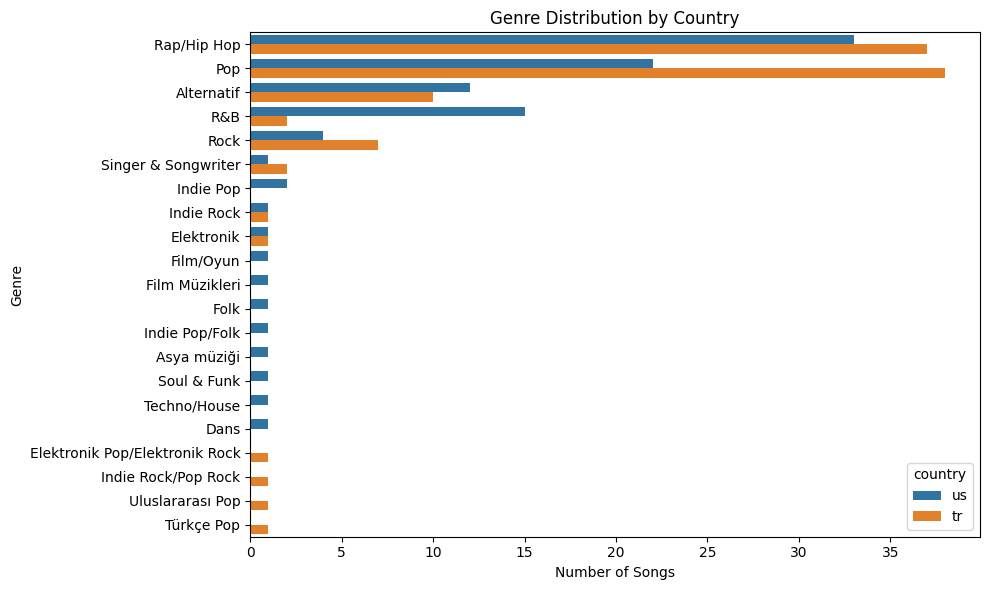

In [25]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    y="deezer_genres",
    hue="country",
    order=df["deezer_genres"].value_counts().index
)

plt.title("Genre Distribution by Country")
plt.xlabel("Number of Songs")
plt.ylabel("Genre")

plt.tight_layout()
plt.show()


- Genre Distribution weighted by Number of Weeks on Charts

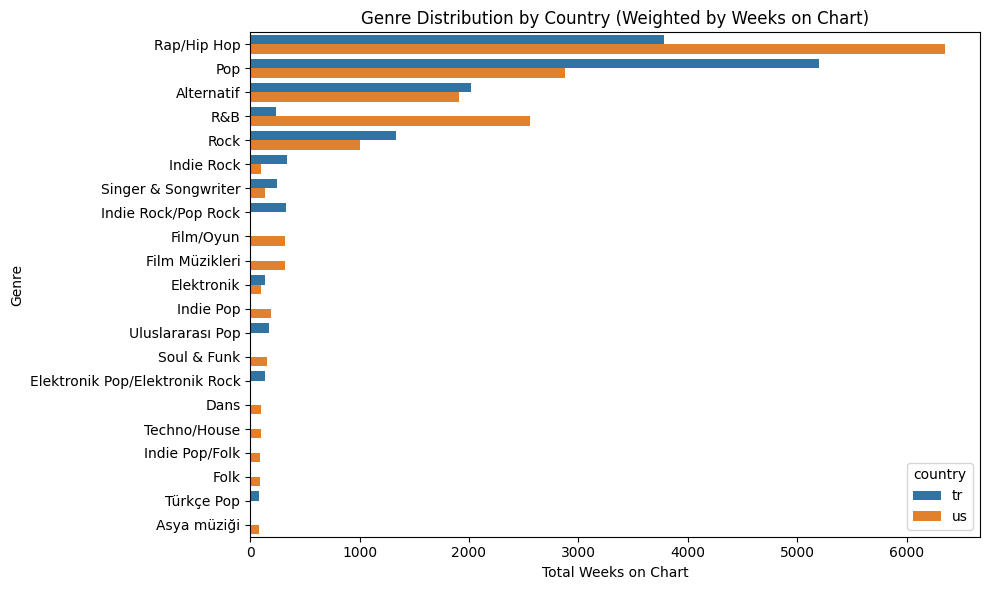

In [26]:
# Aggregate
genre_wks = (
    df.groupby(["deezer_genres", "country"])["wks"]
      .sum()
      .reset_index()
)

# Order by total weight
order_wks = (
    genre_wks.groupby("deezer_genres")["wks"]
             .sum()
             .sort_values(ascending=False)
             .index
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=genre_wks,
    y="deezer_genres",
    x="wks",
    hue="country",
    order=order_wks
)

plt.title("Genre Distribution by Country (Weighted by Weeks on Chart)")
plt.xlabel("Total Weeks on Chart")
plt.ylabel("Genre")

plt.tight_layout()
plt.show()


- Genre Distribution weighted by Number of Weeks A track Appears on Top10

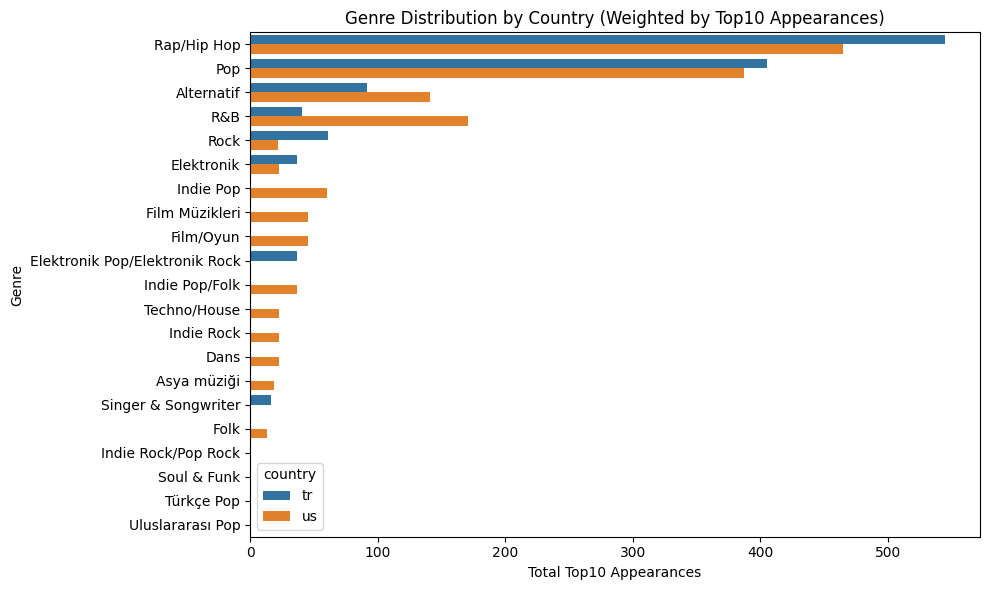

In [27]:
genre_t10 = (
    df.groupby(["deezer_genres", "country"])["t10"]
      .sum()
      .reset_index()
)

order_t10 = (
    genre_t10.groupby("deezer_genres")["t10"]
             .sum()
             .sort_values(ascending=False)
             .index
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=genre_t10,
    y="deezer_genres",
    x="t10",
    hue="country",
    order=order_t10
)

plt.title("Genre Distribution by Country (Weighted by Top10 Appearances)")
plt.xlabel("Total Top10 Appearances")
plt.ylabel("Genre")

plt.tight_layout()
plt.show()


- Genre Distribution weighted by Total Streams

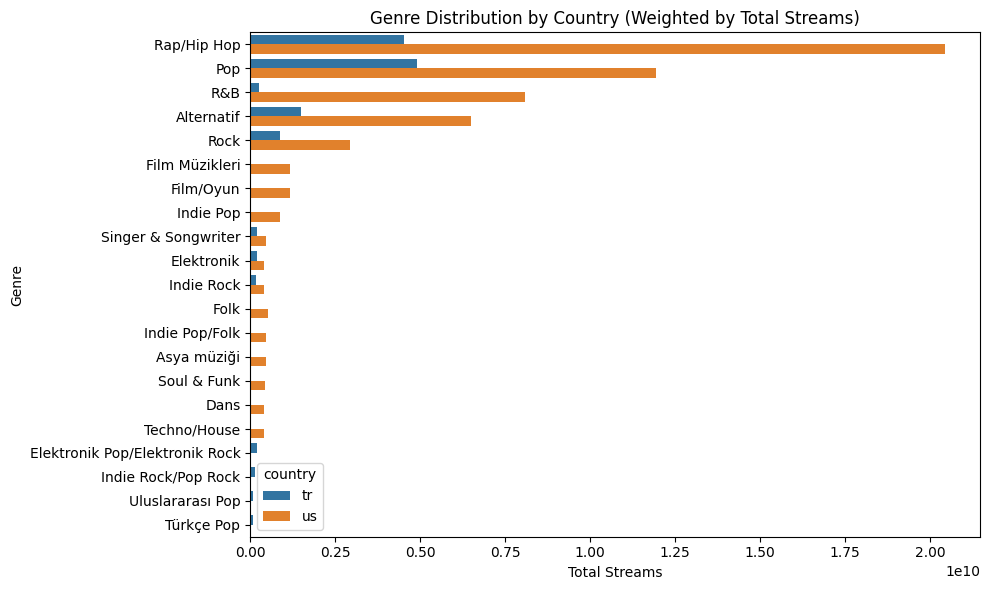

In [28]:
genre_total = (
    df.groupby(["deezer_genres", "country"])["total"]
      .sum()
      .reset_index()
)

order_total = (
    genre_total.groupby("deezer_genres")["total"]
               .sum()
               .sort_values(ascending=False)
               .index
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=genre_total,
    y="deezer_genres",
    x="total",
    hue="country",
    order=order_total
)

plt.title("Genre Distribution by Country (Weighted by Total Streams)")
plt.xlabel("Total Streams")
plt.ylabel("Genre")

plt.tight_layout()
plt.show()
